# Linear models for regression

In this notebook we will examine different ways to train linear models for a regression problem. In this problem we have a dataset of N input variables $\mathbf{X} = \lbrace\mathbf{x}_1, ..., \mathbf{x}_N\rbrace$ together with their target values $\mathbf{T} = \lbrace\mathbf{t}_1, ..., \mathbf{t}_N\rbrace$, and we would like to learn a model that captures the dependency of the targets on the input variables (note that we don't make any assumptions on the dimensionality of the $\mathbf{x}_i$ or $\mathbf{t}_i$).


A linear model for regression can be written in general as

$$y(\mathbf{x}, \mathbf{w}) = \sum_{j=1}^M w_j\phi_j(\mathbf{x}) = \mathbf{w}^T\boldsymbol{\phi}(\mathbf{x})$$

which is simply a linear combination of features obtained from the input variables. These features are also known as *basis functions*, which can be linear (such that $\boldsymbol{\phi}(\mathbf{x}) = \mathbf{x}$) but also **nonlinear**, such as polynomial, gaussian, or sigmoid functions. Being able to examine multiple basis functions will allow us to experiment with models of different complexities.

## A simple dataset
We will generate synthetic data by taking 10 samples from a sinusoidal signal with added gaussian noise. We then fit four polynomials of different degrees *M* using a linear regression model, and plot the resulting predictions for them.

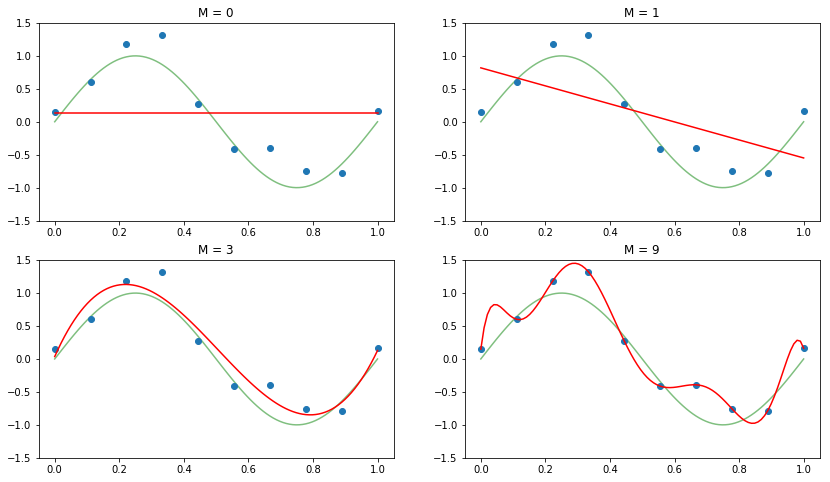

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from linear_models.linear_regression import LinearRegression
from features.basis_functions import polynomial_basis
from data.synthetic import sin_normal_noise
np.random.seed(42)

x_true, t_true, x, t = sin_normal_noise(10)

plt.figure(figsize=(14, 8))
for i, degree in enumerate([0, 1, 3, 9]):
    # Train model
    features = polynomial_basis(x, degree)
    model = LinearRegression()
    model.fit(features, t)
    
    # Make prediction
    prediction = model.predict(polynomial_basis(x_true, degree))
    plt.subplot(2, 2, i+1)
    plt.plot(x_true, t_true, "g", alpha=0.5)
    plt.plot(x, t, "o")
    plt.plot(x_true, prediction, "r")
    plt.ylim((-1.5, 1.5))
    plt.title("M = " + str(degree))

We can clearly see how increasing the complexity of the model in turn increases its performance on predicting for regions of unseen data. After a certain value of the order of the polynomial, however, the model attempts to match exactly each of the points in the training set, that is, the model is **overfitting**.
The previous plots allow us to get a qualitative measure of fit. Nevertheless, a machine learning model should be evaluated under an unambiguous metric, such as the log-likelihood (which is maximized when the parameters of the model are fit), or the Root Mean Square Error (RMSE). The RMSE is defined as

$$E_{RMSE}(\mathbf{w}) = \sqrt{\frac{1}{N} \sum_{i=1}^N (y(\mathbf{x}_i, \mathbf{w}) - t_i})^2$$

We can now examine the precise effect model complexity has on generalization, by evaluating a trained model on two sets: a training and a test set. The training set will consist of the same 10 points as before, and the test set will consist of 100 new points (which are likely to be different due to the normal noise in the data).

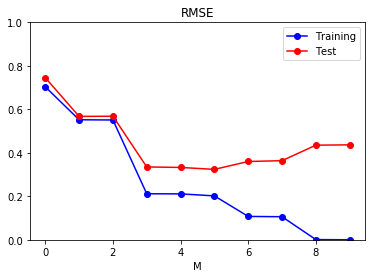

In [2]:
from metrics.regression import rmse

_, _, x_test, t_test = sin_normal_noise(100)

train_error = []
test_error = []
for degree in range(10):
    # Train model
    features = polynomial_basis(x, degree)
    model = LinearRegression()
    model.fit(features, t)
    
    # Predict for train and test sets
    y_train = model.predict(features)
    y_test = model.predict(polynomial_basis(x_test, degree))
    
    # Store errors
    train_error.append(rmse(y_train, t))
    test_error.append(rmse(y_test, t_test))
    
# Plot RMSE vs polynomial degree
plt.plot(train_error, "bo-", label="Training")
plt.plot(test_error, "ro-", label="Test")
plt.ylim([0, 1])
plt.title("RMSE")
plt.xlabel("M")
plt.legend()

Note how the model seems to reduce the error both in the training and validation sets, until the degree of the polynomial is 5. Further increasing the complexity of the model reduces the error in the training set, but increases it in the test set: the model overfits to the training data.

## Introducing regularization

The previous linear models were fitted using what is known as Maximum Likelihood Estimation, in which we find the values of the parameters of the model that maximize the likelihood given the observed data. Therefore, the values these parameters can take are not constrained: the set of estimated parameters can have ***any*** values as long as they maximize the likelihood given the **observed data**, which explains why the model tends to overfit to the training set as its complexity increases. This problem can be solved by introducing additional information via a process known as regularization. In the context of linear regression, regularization allows us to constrain the values that the parameters can take.

There are two ways to introduce regularization for linear regression:
- Introducing a penalty on the size of the weights in the cost function that is minimized during the training process, so that lower weights reduce the cost.
- Introducing a prior probability distribution on the weights and (instead of maximizing the likelihood) maximizing the posterior probability of the parameters given the observed data. This is known as Maximum A Posteriori estimation.

If the prior is a normal distribution the two ways are roughly equivalent, and the amount of regularization is controlled by a single parameter $\lambda$. Given a fixed polynomial degree *M* = 9, let's observe the effect of regularization on generalization:

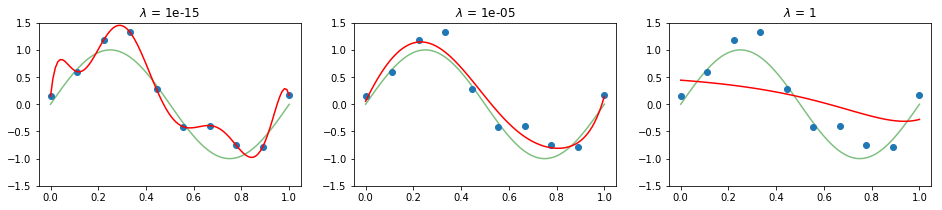

In [3]:
degree = 9
plt.figure(figsize=(16, 3))
for i, lamb in enumerate([1e-15, 1e-5, 1]):
    # Train regularized model
    features = polynomial_basis(x, degree)
    model = LinearRegression(lamb)
    model.fit(features, t)
    
    # Make prediction
    prediction = model.predict(polynomial_basis(x_true, degree))
    plt.subplot(1, 3, i+1)
    plt.plot(x_true, t_true, "g", alpha=0.5)
    plt.plot(x, t, "o")
    plt.plot(x_true, prediction, "r")
    plt.ylim((-1.5, 1.5))
    plt.title("$\lambda$ = " + str(lamb))    

We can observe how the regularization factor constrains the weights of the model and thus its ability to generalize well to unseen data. Even though we have chosen to study fixed values for the degree of the polynomial and the regularization factor, in practical applications we might want to automate the selection of these hyperparameters via grid search, for instance, so as to select the best set of hyperparameters given the performance on a validation set.